In [25]:
import matplotlib.pyplot as plt
import pandas as pd
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
import yfinance as yf

In [26]:
def get_forex_data_yahoo(symbol, start, end):
    df = yf.download(symbol, start=start, end=end, interval='1mo')
    df = df[['Close']].rename(columns={'Close': f'{symbol}_close'})
    return df

start_date = '2014-01-01'
end_date = '2024-01-01'

eur_usd = get_forex_data_yahoo('EURUSD=X', start=start_date, end=end_date)
gbp_usd = get_forex_data_yahoo('GBPUSD=X', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [27]:
forex_data = pd.merge(eur_usd, gbp_usd, left_index=True, right_index=True).dropna()
forex_data.head()

,EURUSD=X_close,GBPUSD=X_close
Date,,
2014-01-01,1.355877,1.649838
2014-02-01,1.370746,1.669198
2014-03-01,1.375213,1.664392
2014-04-01,1.381368,1.682425
2014-05-01,1.363457,1.675912


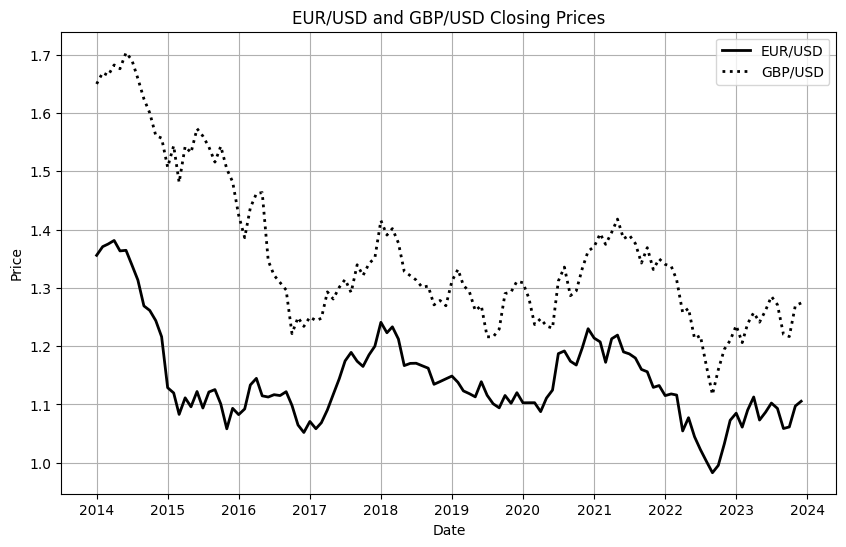

In [28]:
plt.figure(figsize=(10, 6))

plt.plot(forex_data['EURUSD=X_close'], label='EUR/USD', color='black', linestyle='-', linewidth=2)
plt.plot(forex_data['GBPUSD=X_close'], label='GBP/USD', color='black', linestyle=':', linewidth=2)

plt.title('EUR/USD and GBP/USD Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()

plt.savefig('forex2.png')
plt.show()

In [29]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, column_name):
    result = adfuller(series)
    print(f'ADF statistics for {column_name}: {result[0]}')
    print(f'p-value for {column_name}: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    if result[1] <= 0.05:
        print(f"{column_name} is stationary")
        print('')
        return True
    else:
        print(f"{column_name} is not stationary")
        print('')
        return False
    print('')

def make_stationary(df):
    stationary_df = pd.DataFrame()
    for column in df.columns:
        series = df[column]
        is_stationary = adf_test(series, column)
        differencing_count = 0
        while not is_stationary:
            series = series.diff().dropna()
            differencing_count += 1
            is_stationary = adf_test(series, column)
            if differencing_count > 2: 
                break
        stationary_df[column] = series
    return stationary_df

stationary_df = make_stationary(forex_data)

ADF statistics for EURUSD=X_close: -2.7574274372930323
p-value for EURUSD=X_close: 0.06461697357723188
Critical Value 1%: -3.4865346059036564
Critical Value 5%: -2.8861509858476264
Critical Value 10%: -2.579896092790057
EURUSD=X_close is not stationary

ADF statistics for EURUSD=X_close: -9.912439143176142
p-value for EURUSD=X_close: 3.143065464494437e-17
Critical Value 1%: -3.4870216863700767
Critical Value 5%: -2.8863625166643136
Critical Value 10%: -2.580009026141913
EURUSD=X_close is stationary

ADF statistics for GBPUSD=X_close: -2.1917507025079708
p-value for GBPUSD=X_close: 0.20925308812589433
Critical Value 1%: -3.4865346059036564
Critical Value 5%: -2.8861509858476264
Critical Value 10%: -2.579896092790057
GBPUSD=X_close is not stationary

ADF statistics for GBPUSD=X_close: -11.221577160818862
p-value for GBPUSD=X_close: 2.0074103825571442e-20
Critical Value 1%: -3.4870216863700767
Critical Value 5%: -2.8863625166643136
Critical Value 10%: -2.580009026141913
GBPUSD=X_close is 

In [30]:
from statsmodels.tsa.vector_ar.vecm import select_order

model = VAR(stationary_df)
x = model.select_order(maxlags=15, trend="c")
print(x.summary())

optimal_lag_aic = x.aic
print(f"Optimal lag length based on AIC: {optimal_lag_aic}")

optimal_lag_bic = x.bic
print(f"Optimal lag length based on BIC: {optimal_lag_bic}")

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -14.86*     -14.81*  3.513e-07*     -14.84*
1       -14.80      -14.65   3.731e-07      -14.74
2       -14.76      -14.50   3.900e-07      -14.65
3       -14.70      -14.35   4.119e-07      -14.56
4       -14.64      -14.19   4.369e-07      -14.46
5       -14.58      -14.02   4.651e-07      -14.36
6       -14.53      -13.87   4.900e-07      -14.26
7       -14.52      -13.76   4.942e-07      -14.22
8       -14.49      -13.63   5.118e-07      -14.14
9       -14.45      -13.49   5.337e-07      -14.06
10      -14.40      -13.33   5.626e-07      -13.97
11      -14.36      -13.19   5.876e-07      -13.89
12      -14.31      -13.04   6.224e-07      -13.79
13      -14.27      -12.90   6.488e-07      -13.72
14      -14.23      -12.75   6.823e-07      -13.63
15      -14.20      -12.62   7.077e-07      -13.56
-------------------------------

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [31]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

jtest = coint_johansen(stationary_df, det_order=0, k_ar_diff=1)

print(f"Eigenvalues of VECM coefficient matrix : {jtest.eig}\n")

trace_test_results = pd.DataFrame(
    {
        "Test statistic": jtest.trace_stat,
        "Critical values (90%)": jtest.trace_stat_crit_vals[:, 0],
        "Critical values (95%)": jtest.trace_stat_crit_vals[:, 1],
        "Critical values (99%)": jtest.trace_stat_crit_vals[:, 2],
    },
    index=["rank=0", "rank<=1"]
)
print(trace_test_results)


Eigenvalues of VECM coefficient matrix : [0.38695998 0.26756764]

         Test statistic  Critical values (90%)  Critical values (95%)  \
rank=0        93.682994                13.4294                15.4943   
rank<=1       36.431961                 2.7055                 3.8415   

         Critical values (99%)  
rank=0                 19.9349  
rank<=1                 6.6349  


In [32]:
vecm_model = VECM(endog=stationary_df, k_ar_diff=0, deterministic="ci").fit()
print(vecm_model.summary())

           Loading coefficients (alpha) for equation EURUSD=X_close           
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1            0.1634      0.041      3.949      0.000       0.082       0.245
           Loading coefficients (alpha) for equation GBPUSD=X_close           
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1            0.4943      0.045     11.076      0.000       0.407       0.582
          Cointegration relations for loading-coefficients-column 1           
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
beta.1         1.0000          0          0      0.000       1.000       1.000
beta.2        -2.4585      0.181    -13.604      0.0

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


The cointegration equation is given by:

$S = \text{constant} + \beta_1 \times \text{(EUR/USD)} + \beta_2 \times \text{(GBP/USD)}$


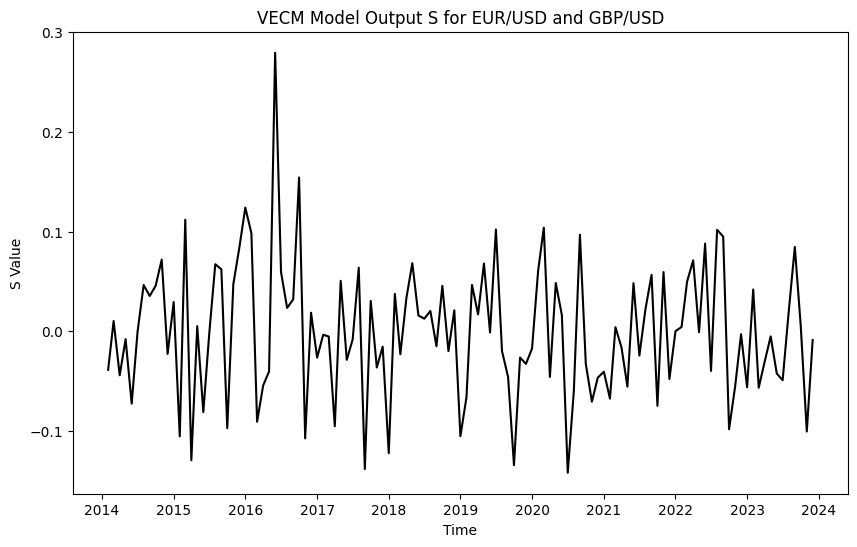

In [33]:
S = (
    vecm_model.const_coint[0][0]
    + vecm_model.beta[0][0] * stationary_df['EURUSD=X_close']
    + vecm_model.beta[1][0] * stationary_df['GBPUSD=X_close']
)

plt.figure(figsize=(10, 6)) 
plt.plot(S, color='black') 
plt.title('VECM Model Output S for EUR/USD and GBP/USD')
plt.xlabel('Time')
plt.ylabel('S Value')
plt.savefig('VECM2.png')
plt.show()